🎨 Visualización 1: RGB Crudo + Máscaras


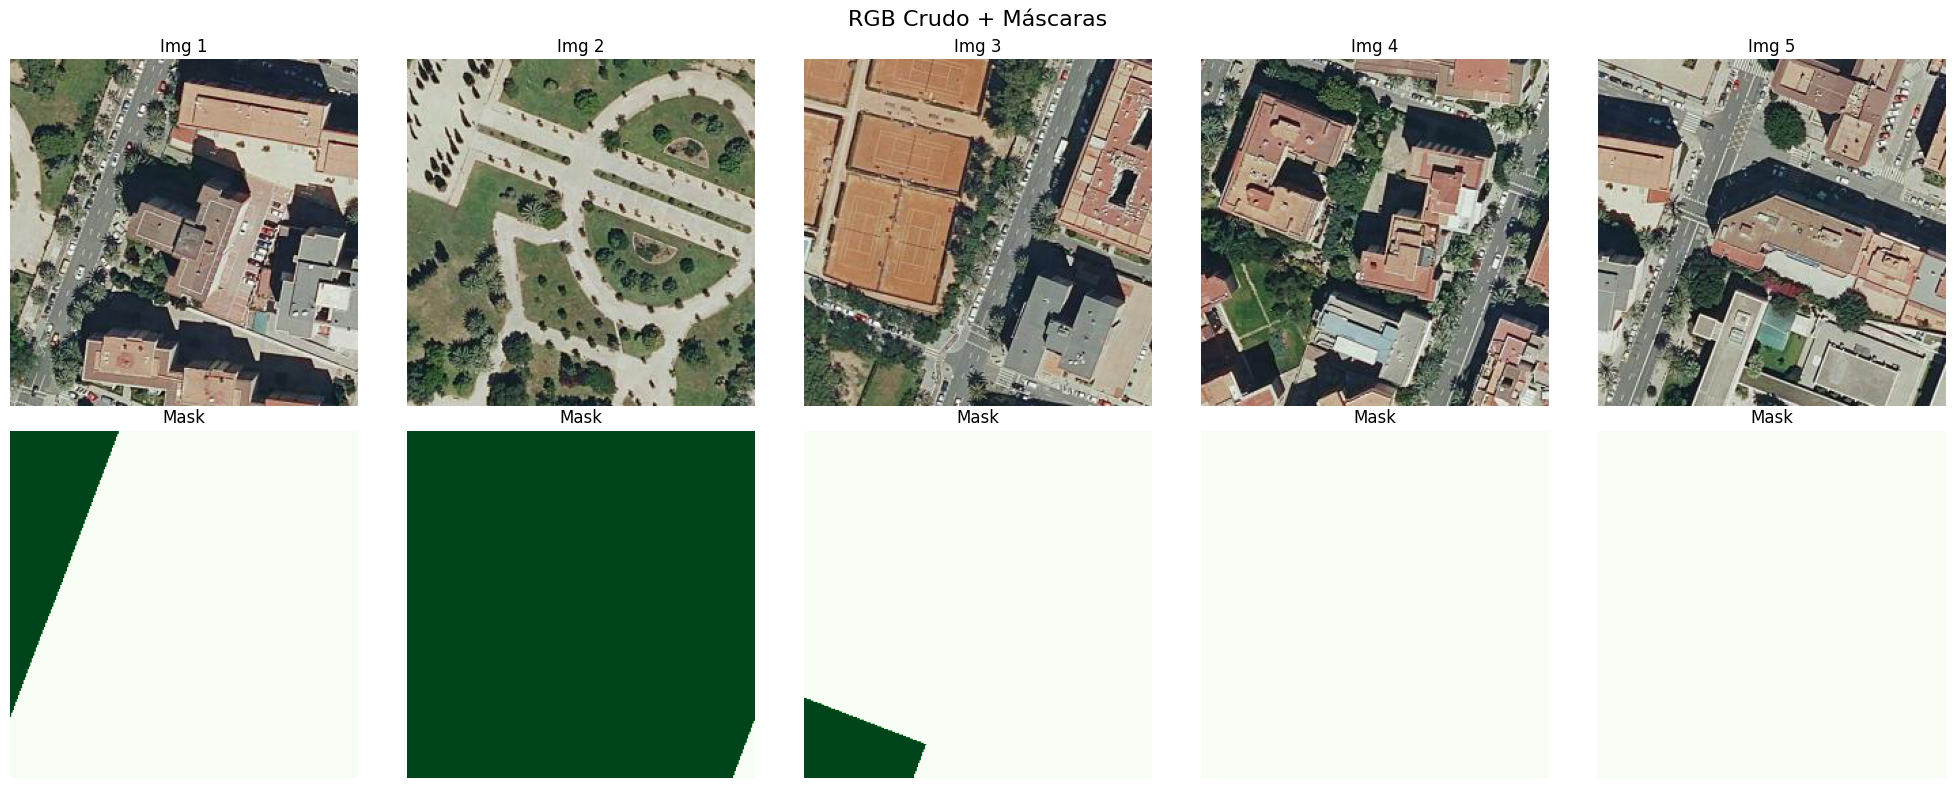


🎨 Visualización 2: RGB Contraste + Máscaras


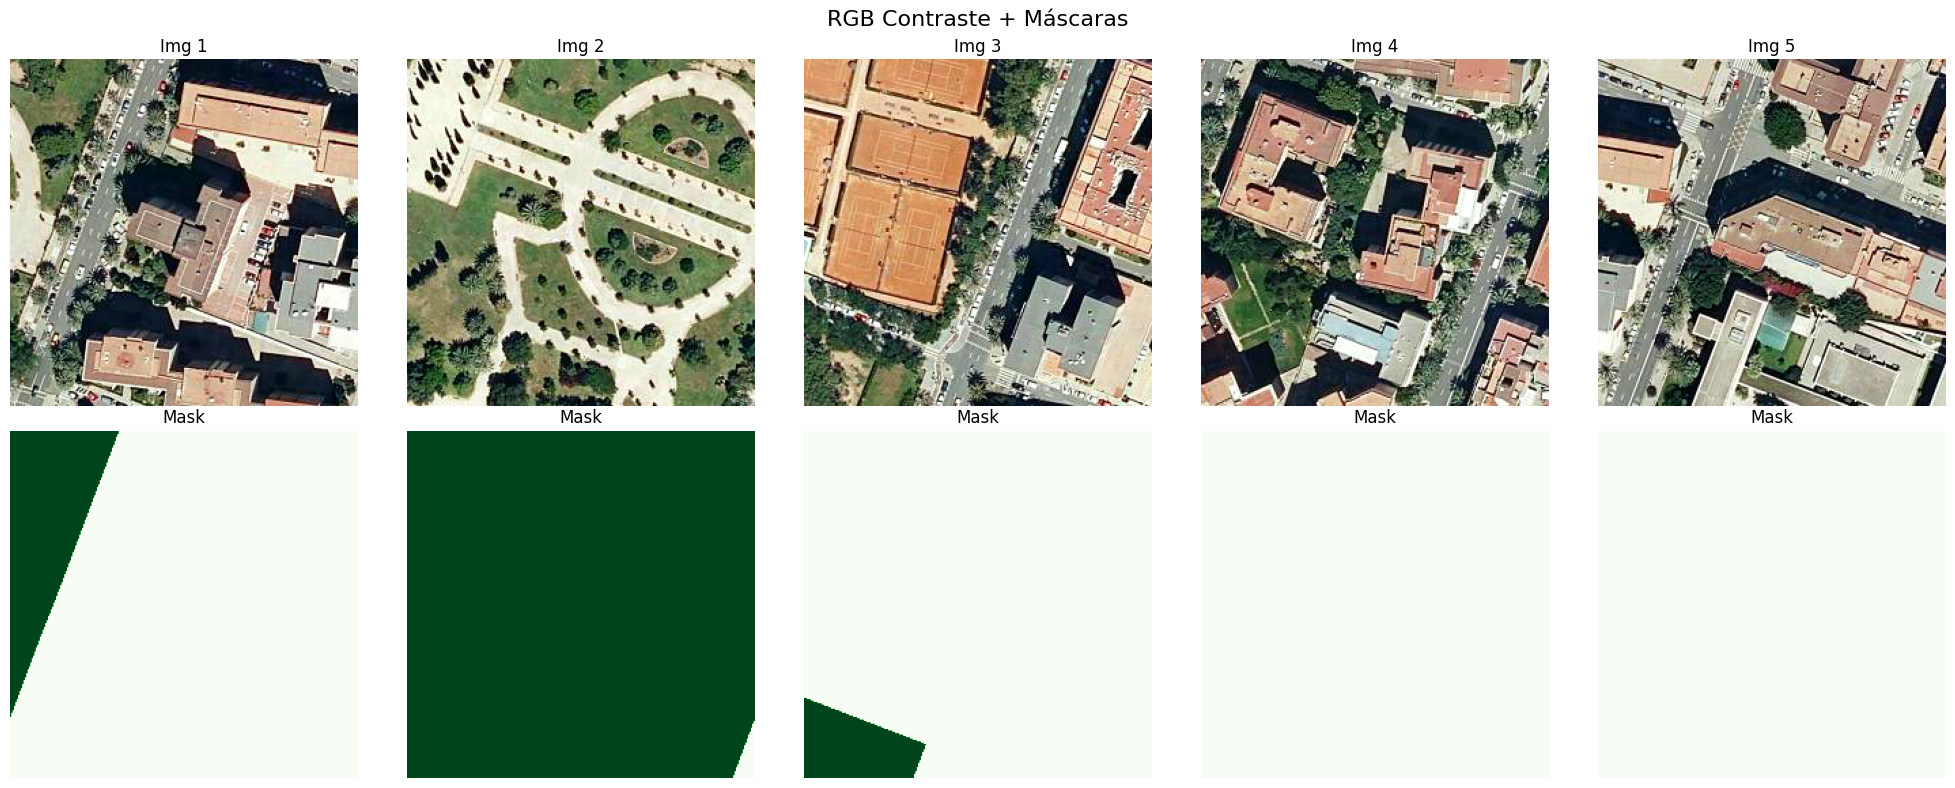


📈 Visualización 3: ExG + Máscaras


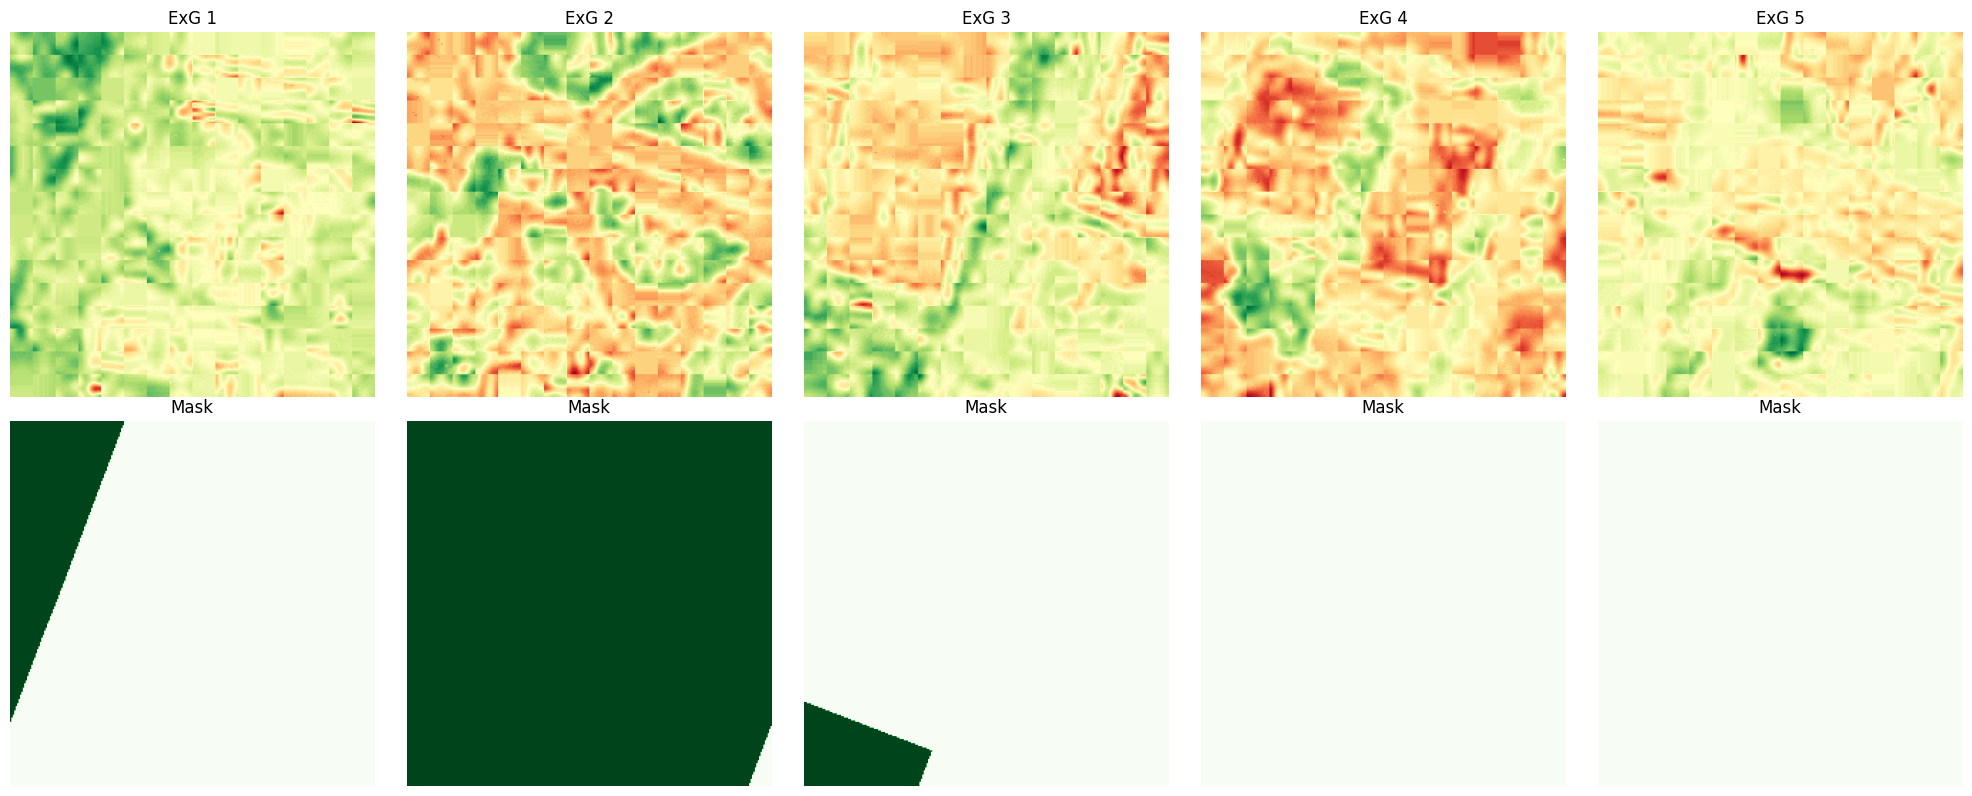


🎨 Visualización 4: Augmentations + Máscaras


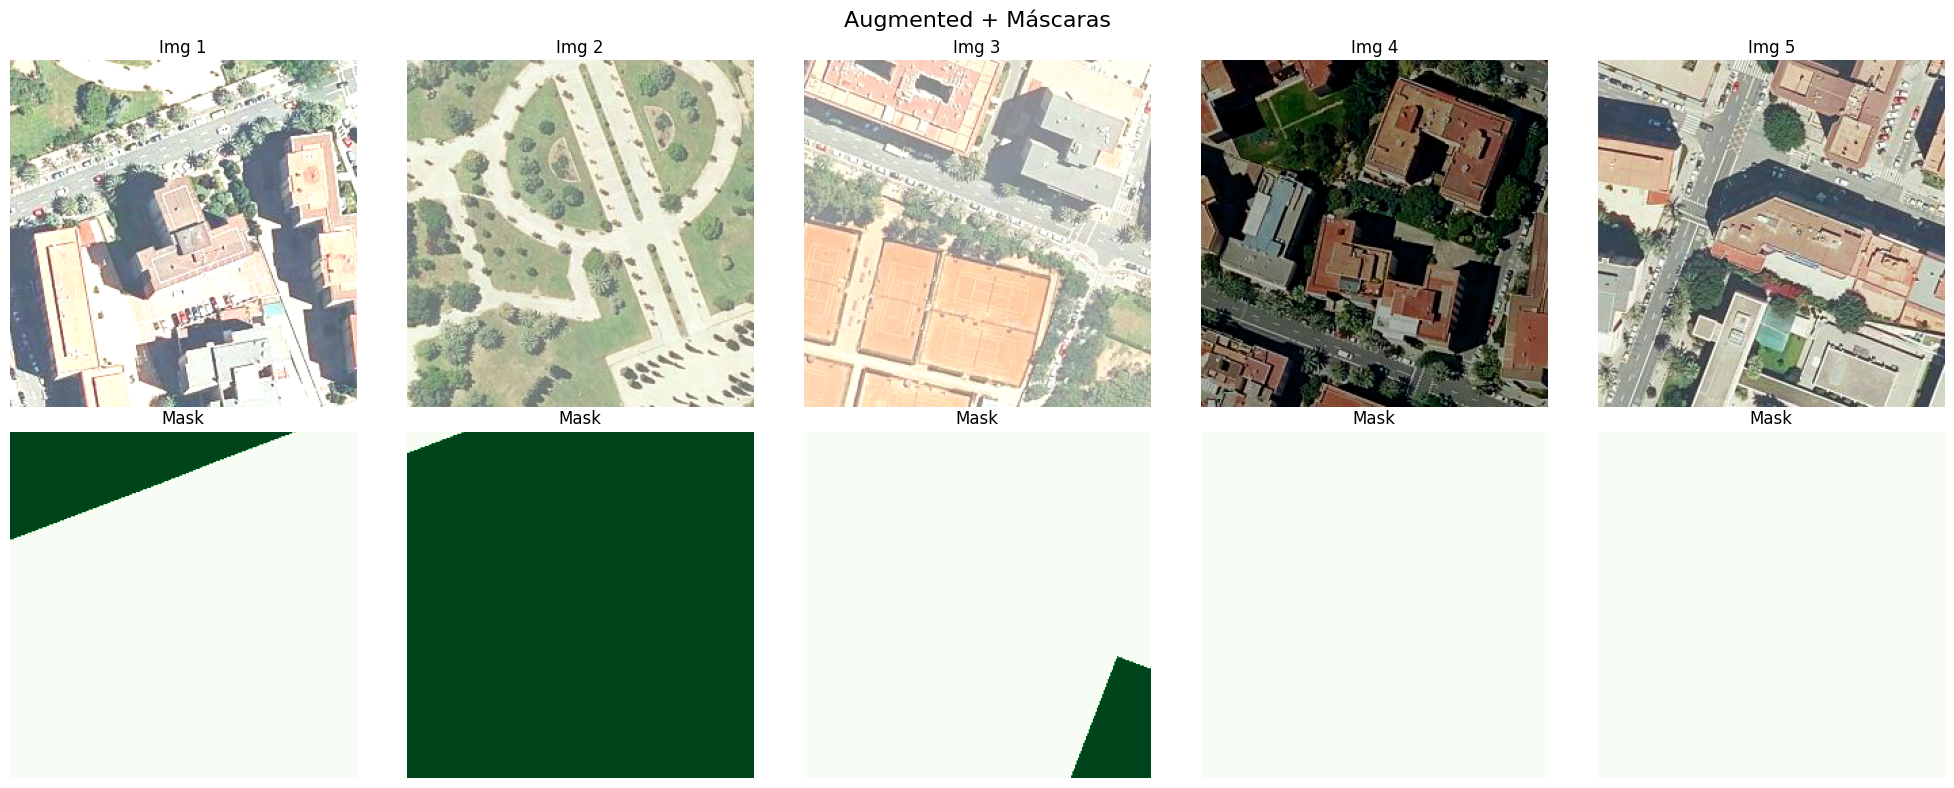

Guardando máscaras: 100%|██████████| 225/225 [05:29<00:00,  1.46s/mask]


In [ ]:
#notebooks/02_Generar_Mascaras.ipynb
# ------------------------------------------------------------------
# 0. IMPORTS Y CONFIG
# ------------------------------------------------------------------

from pathlib import Path
import geopandas as gpd
import logging
import sys
from tqdm import tqdm
import numpy as np
import rasterio
from rasterio.errors import NotGeoreferencedWarning, ShapeSkipWarning
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import matplotlib.pyplot as plt
import tensorflow as tf
import mercantile
from shapely.geometry import Polygon

import warnings
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
warnings.filterwarnings("ignore", category=ShapeSkipWarning)

%load_ext autoreload
%autoreload 2

# Configuración Valencia
PROJECT_ROOT = Path().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT / 'scripts'))
from valencia_config import VALENCIA

# Rutas 
RAW_DIR = PROJECT_ROOT / 'data' / 'raw' / 'pnoa'
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
PROCESSED_DIR.mkdir(exist_ok=True)

# ------------------------------------------------------------------
# 1. CARGA DE ZONAS VERDES Y REPROYECCIÓN a EPSG:4326
# ------------------------------------------------------------------

green_gdf = gpd.read_file(PROCESSED_DIR / 'valencia_zonas_verdes.gpkg')
green_gdf = green_gdf.to_crs('EPSG:4326')
geoms = [geom for geom in green_gdf.geometry if geom is not None and not geom.is_empty]

# ------------------------------------------------------------------
# 2. SELECCIÓN DE 5 TILES CENTRALES
# ------------------------------------------------------------------

tiles = gpd.read_file(RAW_DIR / 'valencia_tiles_grid.geojson')
ctr = mercantile.tile(VALENCIA['center_wgs'][1], VALENCIA['center_wgs'][0], VALENCIA['zoom'])
tiles['dist2'] = (tiles.x - ctr.x)**2 + (tiles.y - ctr.y)**2
tiles = tiles.nsmallest(5, 'dist2').reset_index(drop=True)

# ------------------------------------------------------------------
# 3. GENERACIÓN DE IMÁGENES, ExG Y MÁSCARAS
# ------------------------------------------------------------------
# Seudo NDVI
def compute_exg(img):
    R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    exg = 2 * G - R - B
    # Normalizar a [0,1]
    exg = (exg - exg.min()) / (exg.max() - exg.min() + 1e-6)
    return exg

images_rgb, images_exg, masks = [], [], []
for row in tiles.itertuples():
    x, y, z = row.x, row.y, row.z
    img_path = RAW_DIR / f"valencia_tile_{x}_{y}_{z}.jpg"

    # Georreferenciar JPEG
    w, s, e, n = mercantile.bounds(x, y, z)
    h = VALENCIA['patch_pixels']
    w_ = VALENCIA['patch_pixels']
    transform = from_bounds(w, s, e, n, h, w_)

    # Leer RGB normalizado
    with rasterio.open(img_path, driver='JPEG', transform=transform, crs='EPSG:4326') as src:
        img = src.read([1, 2, 3]).transpose(1, 2, 0).astype(np.float32) / 255.0

    # Calcular ExG
    exg = compute_exg(img)

    # Rasterizar máscara binaria
    mask = rasterize(
        [(geom, 1) for geom in geoms],
        out_shape=(h, w_),
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    images_rgb.append(img)
    images_exg.append(exg)
    masks.append(mask)

# ------------------------------------------------------------------
# 4. FUNCIONES DE VISUALIZACIÓN
# ------------------------------------------------------------------

def stretch_contrast(img, pmin=2, pmax=98):
    vmin, vmax = np.percentile(img, (pmin, pmax))
    return np.clip((img - vmin) / (vmax - vmin), 0, 1)


def visualize_batch(imgs, msks, title, contrast=False):
    n = len(imgs)
    fig, axs = plt.subplots(2, n, figsize=(4*n, 8))
    fig.suptitle(title, fontsize=16)
    for i, (im, msk) in enumerate(zip(imgs, msks)):
        disp = stretch_contrast(im) if contrast else im
        axs[0, i].imshow(disp)
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Img {i+1}")
        axs[1, i].imshow(msk, cmap='Greens')
        axs[1, i].axis('off')
        axs[1, i].set_title('Mask')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 5. VISUALIZACIONES RGB, ExG Y MÁSCARAS
# ------------------------------------------------------------------

print("🎨 Visualización 1: RGB Crudo + Máscaras")
visualize_batch(images_rgb, masks, 'RGB Crudo + Máscaras')

print("\n🎨 Visualización 2: RGB Contraste + Máscaras")
visualize_batch(images_rgb, masks, 'RGB Contraste + Máscaras', contrast=True)

print("\n📈 Visualización 3: ExG + Máscaras")
fig, axs = plt.subplots(2, len(images_exg), figsize=(4*len(images_exg), 8))
for i, exg in enumerate(images_exg):
    axs[0, i].imshow(exg, cmap='RdYlGn')
    axs[0, i].axis('off')
    axs[0, i].set_title(f"ExG {i+1}")
    axs[1, i].imshow(masks[i], cmap='Greens')
    axs[1, i].axis('off')
    axs[1, i].set_title('Mask')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 6. DATA AUGMENTATION
# ------------------------------------------------------------------

def apply_augmentation(img, msk):
    img_t = tf.convert_to_tensor(img, dtype=tf.float32)
    msk_t = tf.expand_dims(tf.convert_to_tensor(msk, dtype=tf.uint8), -1)
    if tf.random.uniform(()) > 0.5:
        img_t = tf.image.flip_left_right(img_t); msk_t = tf.image.flip_left_right(msk_t)
    if tf.random.uniform(()) > 0.5:
        img_t = tf.image.flip_up_down(img_t);    msk_t = tf.image.flip_up_down(msk_t)
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img_t = tf.image.rot90(img_t, k); msk_t = tf.image.rot90(msk_t, k)
    img_t = tf.image.random_brightness(img_t, max_delta=0.4)
    img_t = tf.image.random_contrast(img_t, lower=0.7, upper=1.3)
    img_t = tf.image.random_saturation(img_t, lower=0.7, upper=1.3)
    img_t = tf.clip_by_value(img_t, 0.0, 1.0)
    return img_t.numpy(), tf.squeeze(msk_t).numpy()

aug_imgs, aug_msks = zip(*(apply_augmentation(im, ms) for im, ms in zip(images_rgb, masks)))
print("\n🎨 Visualización 4: Augmentations + Máscaras")
visualize_batch(aug_imgs, aug_msks, 'Augmented + Máscaras')

# ------------------------------------------------------------------
# 7. GENERACIÓN Y GUARDADO DE MÁSCARAS PARA TODO EL CONJUNTO
# -----------------------------------------------------------------

logging.info("🎭 Generando máscaras para todas las imágenes…")
for img_path in tqdm(
    list(RAW_DIR.glob("valencia_tile_*.jpg")),
    desc="Guardando máscaras",
    unit="mask"
):
    basename = img_path.stem
    mask_path = PROCESSED_DIR / f"{basename}_MASK.tif"
    # Georreferenciar JPEG
    x, y, z = map(int, basename.split("_")[-3:])  # tile_x, tile_y, tile_z
    w, s, e, n = mercantile.bounds(x, y, z)
    h = VALENCIA['patch_pixels']; w_ = VALENCIA['patch_pixels']
    transform = from_bounds(w, s, e, n, h, w_)
    profile = {
        'driver': 'GTiff',
        'height': h,
        'width': w_,
        'count': 1,
        'dtype': 'uint8',
        'crs': 'EPSG:4326',
        'transform': transform
    }
    mask = rasterize(
        [(geom, 1) for geom in geoms],
        out_shape=(h, w_),
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    # Guardar
    with rasterio.open(mask_path, 'w', **profile) as dst:
        dst.write(mask, 1)
    rel = mask_path.relative_to(PROJECT_ROOT)
    logging.info(f"📁 Máscara guardada en {rel}")